In [49]:
import sys
import subprocess

#import pkg_resources
#required = {'harmonypy','sklearn','scanpy','pandas', 'numpy', 'bbknn', 'scipy', 'matplotlib', 'seaborn' ,'scipy'}
#installed = {pkg.key for pkg in pkg_resources.working_set}
#missing = required - installed
#if missing:
#    print("Installing missing packages:" )
#    print(missing)
#    python = sys.executable
#    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

%matplotlib inline
from collections import Counter
from collections import defaultdict
import scanpy as sc
import pandas as pd
import pickle as pkl
import numpy as np
from bbknn import bbknn
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys
from geosketch import gs
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import sklearn
import harmonypy as hm
from pathlib import Path

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=300, color_map='viridis')
plt.rcParams['figure.figsize'] = [15, 15]

In [50]:
col_pal = [
    '#ff0000',
    '#94BFB1',
    '#B49EC8',
    '#E0EE70',
    '#EE943E',
    '#4C7BAB',
    '#E78AB8',
    '#AFBFCC',
    '#814F75',
    "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
    "#5A0007", "#809693", "#6A3A4C", "#1B4400", "#4FC601", "#3B5DFF"
]

In [51]:
run_name = 'YS_fliv_progen_trajectory_with_HE_290921'
save_loc = '/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/FDG_FIG2/'
Object = '/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/A4_V7_Combined_YS_Fliver_20210914.h5ad'
save_path = "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/LR_YS_LIV"

# Required: Name of first object
data2 = "_ys"
# Provide categorical to join between datasets
cat2 = "cell.labels"

# Required: Name of second object
data1 = "_fliv"
# Provide categorical to join between datasets
cat1 = "cell.labels"

In [52]:
import os
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
adata = sc.read(Object)
adata.obs.columns

Index(['cell.labels', 'stage', 'lanes', 'sex', 'sort.ids', 'fetal.ids',
       'component', 'broad_cell.labels', 'sequencing.type', 'orig.dataset',
       'broad_cell_labels_organ', 'tissue', 'tissue_fetal_id'],
      dtype='object')

# Update adata metadata

In [53]:
obs = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/Combined_YS_Fliver_meta_20210929.csv',index_col=0)
adata.obs = obs

In [54]:
common_cat = "corr_concat" 
adata.obs[common_cat] = "corr_concat"
adata.obs.loc[adata.obs['tissue'].isin(['YS']),common_cat] = adata.obs.loc[adata.obs['tissue'].isin(['YS']),cat1].astype(str) + data2
adata.obs.loc[adata.obs['tissue'].isin(['Liver']),common_cat] = adata.obs.loc[adata.obs['tissue'].isin(['Liver']),cat2].astype(str) + data1

# Mod both data manually

In [55]:
adata.obs.columns

Index(['cell.labels', 'stage', 'lanes', 'sex', 'sort.ids', 'fetal.ids',
       'component', 'broad_cell.labels', 'sequencing.type', 'orig.dataset',
       'broad_cell_labels_organ', 'tissue', 'corr_concat'],
      dtype='object')

In [56]:
adata.obs["lr_batch"]  = adata.obs["tissue"].astype(str) + '_' +  adata.obs['fetal.ids'].astype(str)

In [57]:
list(adata.obs["lr_batch"].unique())

['YS_Wang_CS10',
 'YS_Wang_CS11',
 'YS_F32',
 'YS_F35',
 'YS_F37',
 'YS_F61',
 'YS_F79',
 'YS_F80',
 'Liver_F61',
 'Liver_F35',
 'Liver_F32']

In [80]:
keep = [
 'MOP_ys',
 'Monocyte_ys',
 'Promonocyte_ys',
'Pre_Macrophage_ys',]

In [81]:
adata = adata[adata.obs[common_cat].isin(keep)]

In [82]:
adata.obs['stage_groups'] = adata.obs['corr_concat'][:]
adata.obs['stage_groups'] = adata.obs['stage_groups'].astype(str)
stages= ['CS7','CS10', 'CS11', 'CS22', 'CS23', 'CS14', 'CS18', 'CS15']
groups = ['CS7','CS10_11', 'CS10_11', 'CS22_23', 'CS22_23', 'CS14_15', 'CS18', 'CS14_15']
dic = dict(zip(stages,groups))
#YS_HSC.obs['stage_groups'] = YS_HSC.obs['stage'].map(dic)
adata.obs.loc[adata.obs['stage'].isin(stages),'stage_groups'] = adata.obs['stage'].map(dic)
adata.obs['stage_groups'].unique()

Trying to set attribute `.obs` of view, copying.


array(['CS10_11', 'CS22_23', 'CS14_15', 'CS18'], dtype=object)

In [83]:
norm_count = ((adata.obs.groupby(['stage_groups',common_cat], observed=True).count()).iloc[:,1]).reset_index()
norm_count.columns = ['stage_groups','is_key','stage']
norm_count

,stage_groups,is_key,stage
0,CS10_11,MOP_ys,10
1,CS10_11,Monocyte_ys,6
2,CS10_11,Pre_Macrophage_ys,24
3,CS10_11,Promonocyte_ys,8
4,CS14_15,MOP_ys,32
5,CS14_15,Monocyte_ys,223
6,CS14_15,Pre_Macrophage_ys,14
7,CS14_15,Promonocyte_ys,40
8,CS18,MOP_ys,79
9,CS18,Monocyte_ys,145


In [84]:
count1 = ((adata.obs.groupby(['stage_groups','corr_concat'], observed=False).count()).iloc[:,1]).reset_index()
count1.columns = ['stage_groups','is_key','stage']
count1['stage'] = count1['stage'].astype(int)
count1['stage'] = count1['stage'] + 1
count2 = count1[:]

for i in count1['stage_groups'].unique():
    for z in count1.index[count1['stage_groups'].isin([i])]:
        count2.loc[count2.index.isin([z]),'stage'] = (count1.loc[count1.index.isin([z]),'stage'] / sum(count1['stage'][count1['stage_groups'].isin([i])]))*100
#count2.set_index(['leiden_mono', 'corr_concat'], inplace=True)

In [102]:
count3 = count2[:]
count3

,stage_groups,is_key,stage
0,CS10_11,MOP_ys,21.153846
1,CS10_11,Monocyte_ys,13.461538
2,CS10_11,Pre_Macrophage_ys,48.076923
3,CS10_11,Promonocyte_ys,17.307692
4,CS14_15,MOP_ys,10.543131
5,CS14_15,Monocyte_ys,71.565495
6,CS14_15,Pre_Macrophage_ys,4.792332
7,CS14_15,Promonocyte_ys,13.099042
8,CS18,MOP_ys,23.598820
9,CS18,Monocyte_ys,43.067847


In [103]:
# count3= pd.read_csv('mono_mopo_counts.csv',index_col=None)
# count3

In [109]:
count3.to_csv('mono_mopo_counts.csv')

In [105]:
count3 
count3.set_index(['stage_groups','is_key'], inplace=True)
count3.iloc[:,0].T.unstack().plot(kind='bar', stacked=False)

<AxesSubplot:xlabel='stage_groups'>

In [106]:
keep2 = [
 'MOP_ys',
 'CMP_ys',
 'Monocyte_ys',
 'Promonocyte_ys','Pre_Macrophage_ys',]

In [99]:
count3 = (count3.reset_index)

In [108]:
count2

,stage_groups,is_key,stage
0,CS10_11,MOP_ys,21.153846
1,CS10_11,Monocyte_ys,13.461538
2,CS10_11,Pre_Macrophage_ys,48.076923
3,CS10_11,Promonocyte_ys,17.307692
4,CS14_15,MOP_ys,10.543131
5,CS14_15,Monocyte_ys,71.565495
6,CS14_15,Pre_Macrophage_ys,4.792332
7,CS14_15,Promonocyte_ys,13.099042
8,CS18,MOP_ys,23.598820
9,CS18,Monocyte_ys,43.067847


In [110]:
count3= pd.read_csv('mono_mopo_counts.csv',index_col=None)
for i in count3['is_key'].unique():
    print(list(count3['stage'][count3['is_key'].isin([i])]))

[21.153846153846157, 10.543130990415335, 23.59882005899705, 23.07692307692308]
[13.461538461538462, 71.56549520766772, 43.067846607669615, 61.53846153846154]
[48.07692307692308, 4.792332268370607, 5.604719764011799]
[17.307692307692307, 13.099041533546329, 27.72861356932153, 15.384615384615383]


In [113]:
count3

,stage_groups,is_key,stage
0,CS10_11,MOP_ys,21.153846
1,CS10_11,Monocyte_ys,13.461538
2,CS10_11,Pre_Macrophage_ys,48.076923
3,CS10_11,Promonocyte_ys,17.307692
4,CS14_15,MOP_ys,10.543131
5,CS14_15,Monocyte_ys,71.565495
6,CS14_15,Pre_Macrophage_ys,4.792332
7,CS14_15,Promonocyte_ys,13.099042
8,CS18,MOP_ys,23.598820
9,CS18,Monocyte_ys,43.067847


In [112]:
count4 = count3[count3['is_key'].isin(["True"])]
count4

,stage_groups,is_key,stage


In [79]:
y3_nan+0.1*100

NameError: name 'y3_nan' is not defined

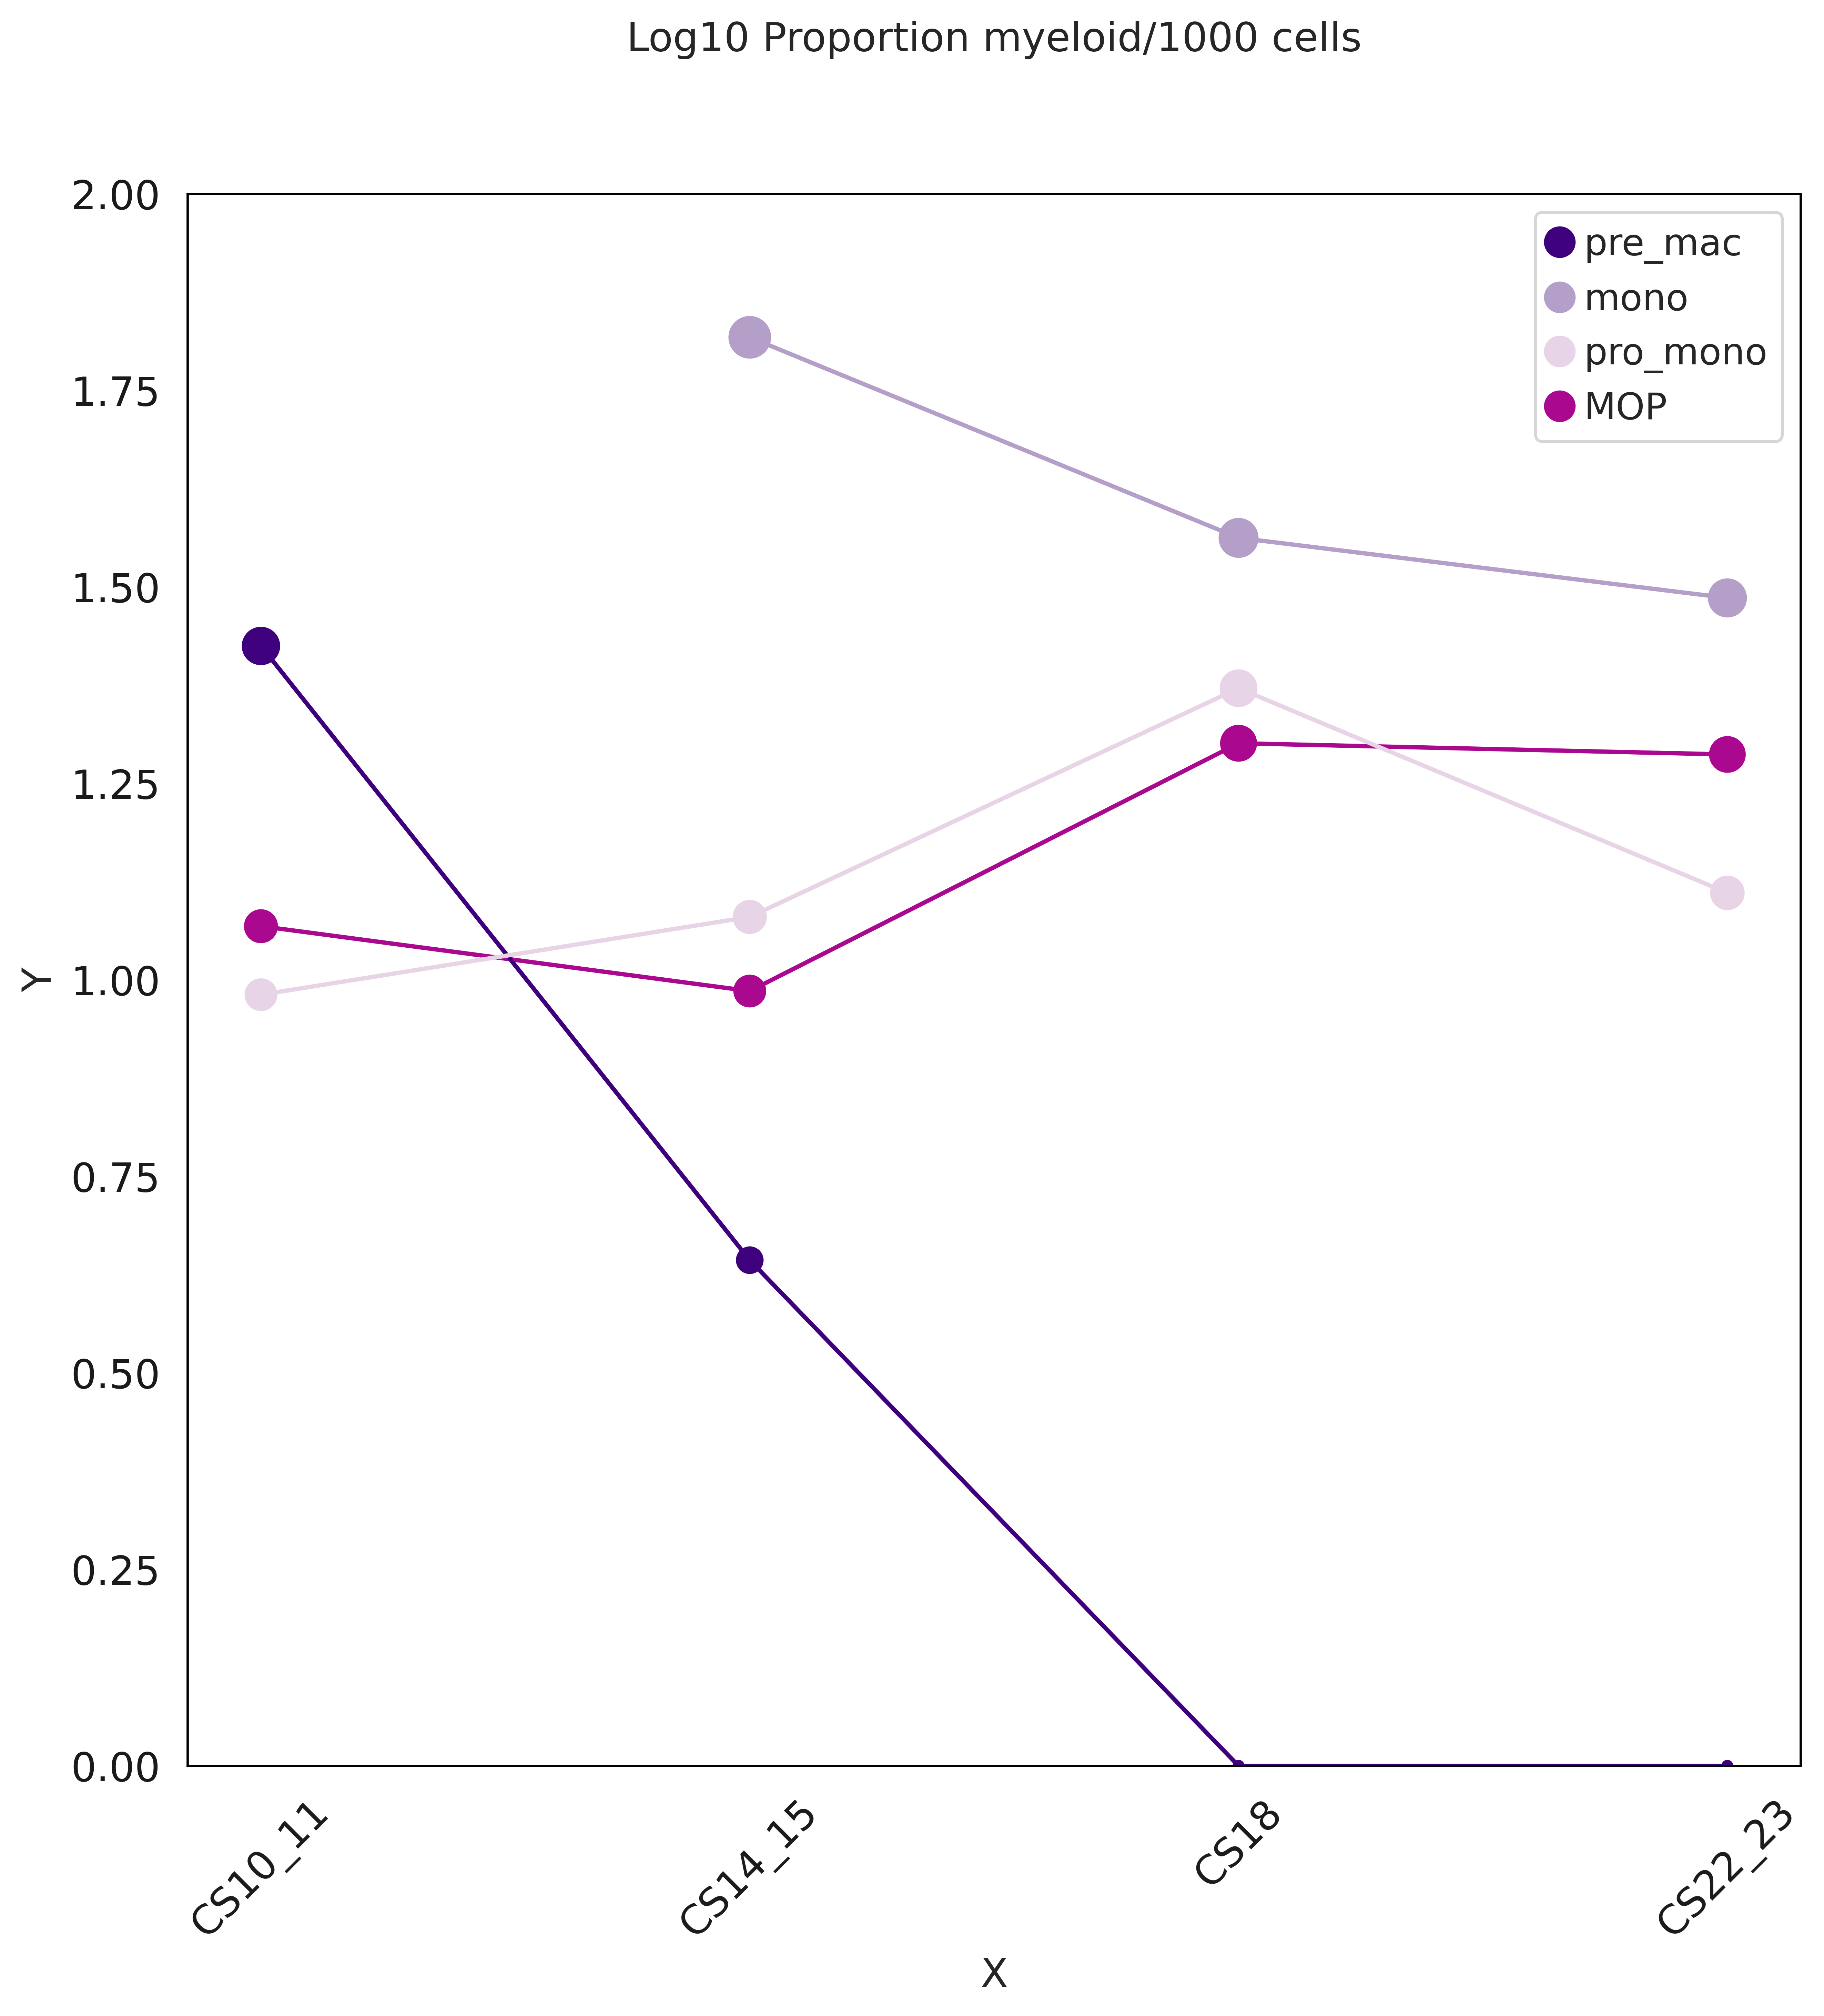

In [118]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
figure(figsize=(10, 10), dpi= 300)

x=[ 'CS10_11', 'CS14_15', 'CS18', 'CS22_23']


#y1_size = np.log10([26, 2180, 6408, 44052, 1402])*100

y2=[11.70212766, 9.677419355, 20.0, 19.35483871] ##MOP

y3 = [1.0, 65.68914956, 36.5, 30.61290323] ## Mono

y4 = [26.59574468, 4.398826979, 1, 1] #Premac

y5 = [9.574468085, 12.02346041, 23.5, 12.90322581] # promono

#y2_size = np.log10([1, 1, 1, 1000, 3005])*100

#y1 = np.log10(y1)
y2 = np.log10(y2)
y2[y2==0 ] = np.nan

y3 = np.log10(y3)
y3_nan = y3.copy()
y3[y3==0 ] = np.nan
y4 = np.log10(y4)
#y4[y4==0 ] = np.nan
y5 = np.log10(y5)
y5[y5==0 ] = np.nan

ymin = 0
ymax = 2

x = np.array(x)
#ax = plt.scatter(x,y1,c="blue") #s = y1_size 
plt.scatter(x,y2,c="#AB0890" ,s=(y2+0.1)*100, marker='o')
plt.plot(y2,c="#AB0890",linestyle = None)
plt.scatter(x,y3_nan,c="#b49fc8" ,s=(y3+0.1)*100, marker='o')
plt.plot(x,y3,c="#b49fc8",linestyle = None)
plt.scatter(x,y4,c="#3e007c", marker='o',s=(y4+0.1)*100 )
plt.plot(y4,c="#3e007c",linestyle = None)
plt.scatter(x,y5,c="#e7d4e7",s=(y5+0.1) *100,marker='o')
plt.plot(y5,c="#e7d4e7",linestyle = None)


plt.xlabel("X")
plt.ylabel("Y")
plt.ylim(ymin, ymax)
plt.title("Log10 Proportion myeloid/1000 cells",y=1.08)
plt.grid(b=False)
#plt.legend()


import matplotlib.lines as mlines
premac = mlines.Line2D([], [], color='#3e007c', marker='o', linestyle='None',
                          markersize=10, label='pre_mac')
mono = mlines.Line2D([], [], color='#b49fc8', marker='o', linestyle='None',
                          markersize=10, label='mono')
promono = mlines.Line2D([], [], color='#e7d4e7', marker='o', linestyle='None',
                          markersize=10, label='pro_mono')
mop = mlines.Line2D([], [], color='#AB0890', marker='o', linestyle='None',
                          markersize=10, label='MOP')
plt.legend(handles=[premac , mono,promono,mop ])


plt.xticks(rotation=45)

plt.savefig('./mono_mye_prop_1000cells.pdf', dpi=300,
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None
       )

In [2]:
import numpy as np

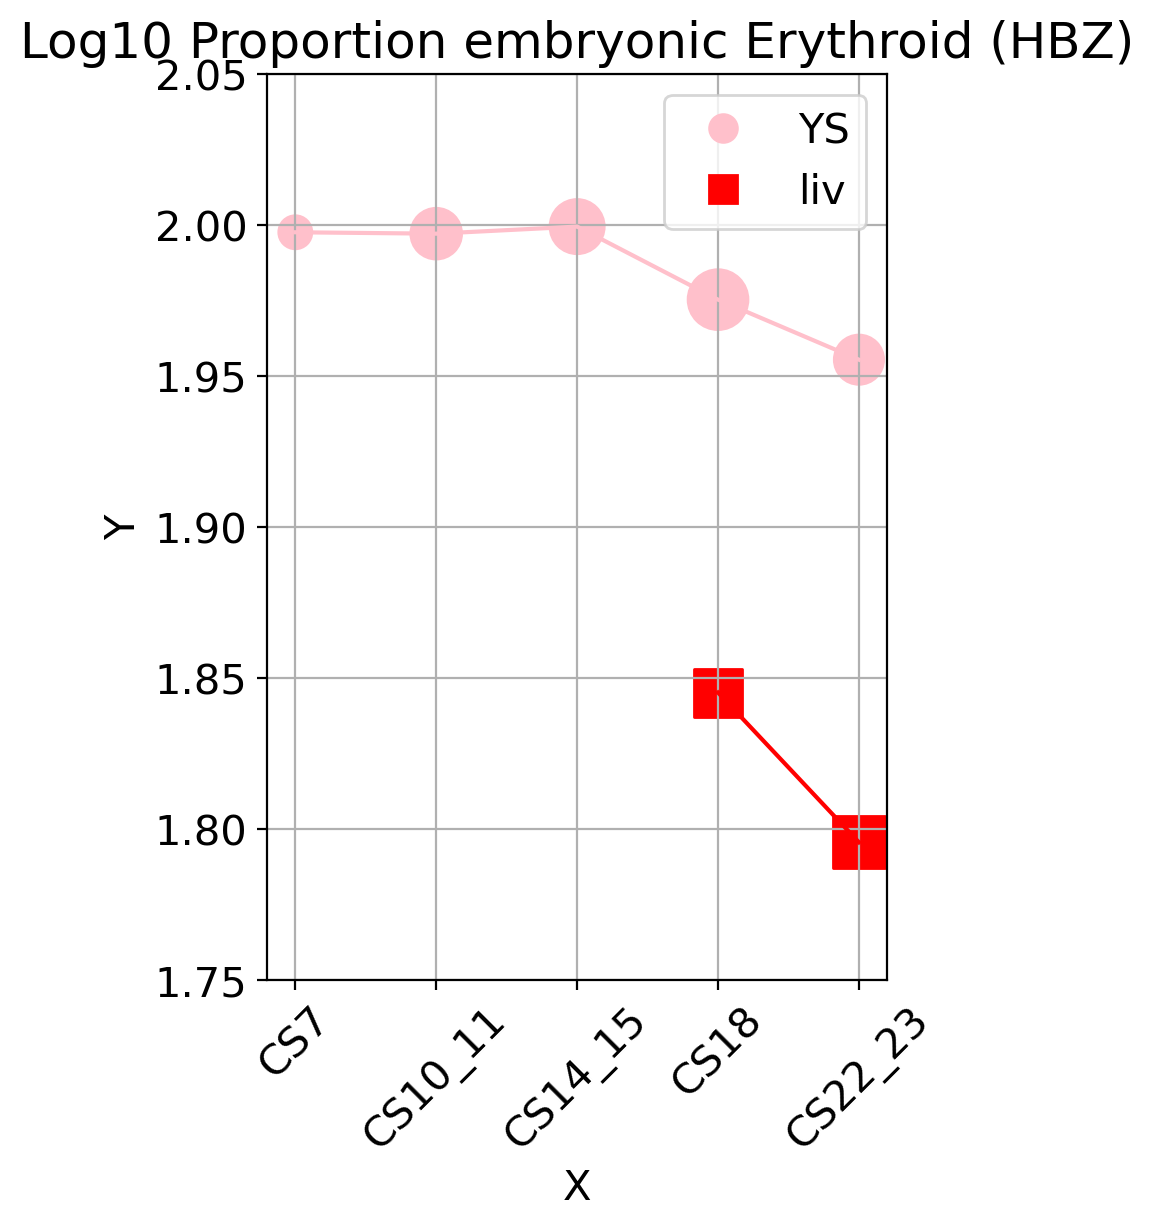

<Figure size 432x288 with 0 Axes>

In [3]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
#figure(figsize=(5, 10), dpi=80)
plt.rcParams.update({'font.size': 15})

x=['CS7', 'CS10_11', 'CS14_15', 'CS18', 'CS22_23']

y1=[99.42857142857143,
 99.32262382864792,
 99.85976939856653,
 94.4514177352357,
 90.22431161853592,]
y1_size = np.log10([26, 2180, 6408, 44052, 1402])*100


y2=[1,
 1,
 1,
 70,
 62.44797286881455]

y2_size = np.log10([1, 1, 1, 1000, 3005])*100

y1 = np.log10(y1)
y2 = np.log10(y2)
ymin = 1.75
ymax = 2.05
y1[y1==0 ] = np.nan
y2[y2==0 ] = np.nan

fig = plt.figure(figsize=(4, 6), dpi=200)
ax1 = fig.add_subplot()

ax1.scatter(x,y1,c='pink',s = y1_size ,marker='o', cmap='turbo'  ) #y1*10
ax1.plot(x,y1,c='pink',linestyle = None)
ax1.scatter(x,y2,c='red',s = y2_size, marker='s', cmap='turbo', )# y1*10
ax1.plot(x,y2,c='red',linestyle = None)
#fig.colorbar(ax, label='arr')
#handles, labels = ax1.legend_elements(prop="sizes", alpha=0.6)
#legend = ax.legend(handles, labels, loc="upper right", title="Sizes")


plt.grid(b=None)
plt.xlabel("X")
plt.ylabel("Y")
plt.ylim(ymin, ymax)
plt.title("Log10 Proportion embryonic Erythroid (HBZ)")
plt.xticks(rotation=45)
plt.axhline(y=0, color='r', linestyle='-')


import matplotlib.lines as mlines
pinkcircle = mlines.Line2D([], [], color='pink', marker='o', linestyle='None',
                          markersize=10, label='YS')
redsquare = mlines.Line2D([], [], color='red', marker='s', linestyle='None',
                          markersize=10, label='liv')
plt.legend(handles=[pinkcircle, redsquare])


plt.show()

plt.savefig('./ery_HBZ_prop.pdf', dpi=300,
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None
       )

In [205]:
y = np.array([ 'na', 1.81749364, 1.56229286, 1.71275829])

In [217]:
x = np.array(x)
if min(y3) == 0:
    print('True')
    y3 = y3[y3>0]
    x3 = x[np.where(y3>0)[0]]

True


In [218]:
x

array(['CS14_15', 'CS18', 'CS22_23'], dtype='<U7')

In [210]:
x[np.where(y3==0)[0]]


TypeError: only integer scalar arrays can be converted to a scalar index

In [207]:
plt.plot(y3,c="green",linestyle = None)

In [189]:
y3

array([0.        , 1.81749364, 1.56229286, 1.71275829])

In [187]:
y3[y3==0.1] = 0
y3

array([0., 0., 0., 0.])

In [222]:
import matplotlib.pyplot as plt
import numpy as np


x = np.linspace(-np.pi/2, np.pi/2, 31)
y = np.cos(x)**3

# 1) remove points where y > 0.7
x2 = x[y <= 0.7]
y2 = y[y <= 0.7]

# 2) mask points where y > 0.7
y3 = np.ma.masked_where(y > 0.7, y)

# 3) set to NaN where y > 0.7
y4 = y.copy()
y4[y3 > 0.7] = np.nan

plt.plot(x*0.1, y, 'o-', color='lightgrey', label='No mask')
plt.plot(x2*0.4, y2, 'o-', label='Points removed')
plt.plot(x*0.7, y3, 'o-', label='Masked values')
plt.plot(x*1.0, y4, 'o-', label='NaN values')
plt.legend()
plt.title('Masked and NaN data')
plt.show()

In [281]:
x

['CS7', 'CS10_11', 'CS14_15', 'CS18', 'CS22_23']

In [278]:
colors = cm.rainbow(np.linspace(0, 1, y.shape[0]))

AttributeError: 'list' object has no attribute 'shape'

# Log10 cellcount for size